In [1]:
!pip install gluonts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.1 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# CSV dosyasını okuyalım
df = pd.read_csv("../input/timeseries/finalData.csv")

# Tarih sütununu indeks olarak ayarlayalım
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.iloc[::-1]

# Veri kümesini eğitim, doğrulama ve test alt kümelerine ayıralım
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
train_df, validation_df = train_test_split(train_df, test_size=0.5, shuffle=False)

# GluonTS'nin kullanabileceği bir format olan ListDataset'e dönüştürelim
def create_dataset(df):
    return [
        {
            FieldName.START: df.index[0],
            FieldName.TARGET: df['TSLA High'].to_numpy(),  # Hedef değişken: TSLA High
            FieldName.FEAT_STATIC_CAT: [0],  # Statik kategorik özellik: placeholder, ihtiyaç varsa ayarlanabilir
            FieldName.FEAT_DYNAMIC_REAL: df[['Bollinger_up', 'Bollinger_mid', 'Bollinger_low']].values.T.tolist(),  # Dinamik gerçel özellikler
            FieldName.ITEM_ID: "TSLA",  # Item ID
        }
    ]

# DatasetDict formatına dönüştürme
train_ds = Dataset.from_pandas(pd.DataFrame(create_dataset(train_df)))
validation_ds = Dataset.from_pandas(pd.DataFrame(create_dataset(validation_df)))
test_ds = Dataset.from_pandas(pd.DataFrame(create_dataset(test_df)))

datasets = DatasetDict({
    'train': train_ds,
    'validation': validation_ds,
    'test': test_ds
})

# Çıktıyı kontrol edelim
print(datasets)


DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 1
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 1
    })
})


In [3]:
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt

# CSV dosyasını okuyalım
df = pd.read_csv("../input/timeseries/finalData.csv")

# Tarih sütununu indeks olarak ayarlayalım
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.iloc[::-1]

# Veri kümesini eğitim, doğrulama ve test alt kümelerine ayıralım
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
train_df, validation_df = train_test_split(train_df, test_size=0.5, shuffle=False)

# GluonTS'nin kullanabileceği bir format olan ListDataset'e dönüştürelim
def create_dataset(df):
    return [
        {
            FieldName.START: df.index[0],
            FieldName.TARGET: df['TSLA High'].to_numpy(),  # Hedef değişken: TSLA High
            FieldName.FEAT_STATIC_CAT: [0],  # Statik kategorik özellik: placeholder, ihtiyaç varsa ayarlanabilir
            FieldName.FEAT_DYNAMIC_REAL: df[['Bollinger_up', 'Bollinger_mid', 'Bollinger_low']].values.T.tolist(),  # Dinamik gerçel özellikler
            FieldName.ITEM_ID: "TSLA",  # Item ID
        }
    ]

In [4]:
# DatasetDict formatına dönüştürme
train_ds = Dataset.from_pandas(pd.DataFrame(create_dataset(train_df)))
validation_ds = Dataset.from_pandas(pd.DataFrame(create_dataset(validation_df)))
test_ds = Dataset.from_pandas(pd.DataFrame(create_dataset(test_df)))

datasets = DatasetDict({
    'train': train_ds,
    'validation': validation_ds,
    'test': test_ds
})

In [5]:
# Çıktıyı kontrol edelim
print(datasets)
train_example = datasets["train"][0]
train_example.keys()
validation_example = datasets["validation"][0]
test_example = datasets["test"][0]
validation_example.keys()
freq = "1D"
prediction_length = 1
print(len(validation_example["target"]))
print(len(train_example["target"]))
assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"])
train_dataset = datasets["train"]
test_dataset = datasets["test"]
from functools import lru_cache

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 1
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 1
    })
})
1901
1900


In [6]:
import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch
from functools import partial
freq = "1D"

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [7]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
  
    context_length=prediction_length * 2,
   
    lags_sequence=lags_sequence,
    
    num_time_features=len(time_features) + 1,
    
    num_static_categorical_features=1,
  
    cardinality=[len(train_dataset)],
   
    embedding_dimension=[2],

    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]
[<function day_of_week at 0x7c644350e9e0>, <function day_of_month at 0x7c644350eb00>, <function day_of_year at 0x7c644350ec20>]


In [8]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig

In [9]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    
    return Chain(
        
        [RemoveFields(field_names=remove_field_names)]
        
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
               
                expected_ndim=1 if config.input_size == 1 else 2,
            ),

            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
          
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
     
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [10]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [11]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)


    instance_splitter = create_instance_splitter(config, "train")

  
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [12]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # We create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [13]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    
    instance_sampler = create_instance_splitter(config, "test")

    
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [14]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=32,
    num_batches_per_epoch=100,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=32,
)

In [15]:

batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([32, 1095, 4]) torch.FloatTensor
past_values torch.Size([32, 1095]) torch.FloatTensor
past_observed_mask torch.Size([32, 1095]) torch.FloatTensor
future_time_features torch.Size([32, 1, 4]) torch.FloatTensor
static_categorical_features torch.Size([32, 1]) torch.LongTensor
future_values torch.Size([32, 1]) torch.FloatTensor
future_observed_mask torch.Size([32, 1]) torch.FloatTensor


In [16]:
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)
print("Loss:", outputs.loss.item())

Loss: 3.1999974250793457


In [17]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

# Initialize an empty list to store the epoch losses
epoch_losses = []

model.train()
num_batches_per_epoch = 0  # Initialize the number of batches per epoch
for epoch in range(40):
    epoch_loss = 0.0  # Initialize the loss for this epoch
    num_batches_per_epoch = 0  # Reset the number of batches per epoch
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        # Accumulate the loss for this epoch
        epoch_loss += loss.item()
        num_batches_per_epoch += 1

        if idx % 100 == 0:
            print(loss.item())
    
    # Calculate the average loss for this epoch and store it
    avg_epoch_loss = epoch_loss / num_batches_per_epoch
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_epoch_loss}")

3.410304069519043
Epoch 1, Loss: 2.468430000543594
1.9228675365447998
Epoch 2, Loss: 1.599195591211319
1.1611733436584473
Epoch 3, Loss: 1.1244319415092467
1.1483404636383057
Epoch 4, Loss: 0.7348845472931862
0.7487393021583557
Epoch 5, Loss: 0.534887775555253
0.5117869973182678
Epoch 6, Loss: 0.3030592345446348
0.14871227741241455
Epoch 7, Loss: 0.2027854411303997
-0.1604423224925995
Epoch 8, Loss: 0.055347335804253814
0.009532421827316284
Epoch 9, Loss: -0.0415481573715806
0.9463891386985779
Epoch 10, Loss: -0.09463475234806537
-0.37405186891555786
Epoch 11, Loss: -0.15333473533391953
-0.3667740225791931
Epoch 12, Loss: -0.19307766657322645
-0.22852839529514313
Epoch 13, Loss: -0.15646555308252574
-0.23028433322906494
Epoch 14, Loss: -0.14152027690783142
-0.07209968566894531
Epoch 15, Loss: -0.24762223117053508
0.26686257123947144
Epoch 16, Loss: -0.2633253253251314
-0.16817043721675873
Epoch 17, Loss: -0.20413062535226345
-0.6000955104827881
Epoch 18, Loss: -0.2682827899605036
-0.38

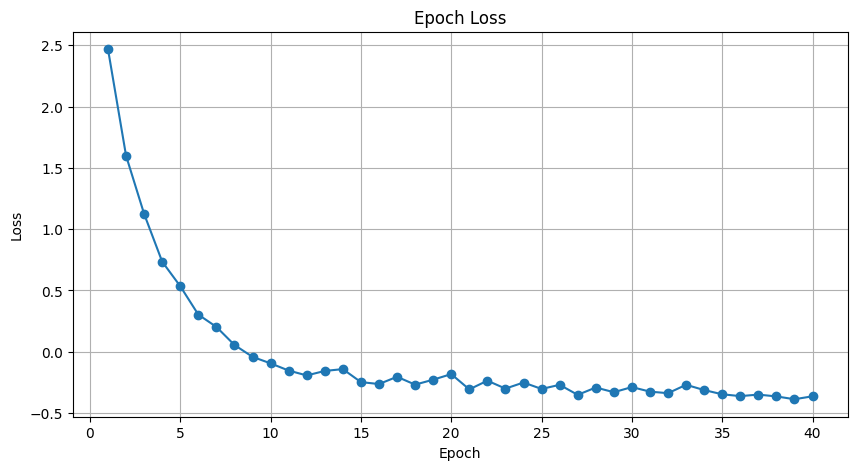

In [18]:
# Plot the epoch loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 41), epoch_losses, marker='o')
plt.title('Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [56]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(1, 100, 1)


In [59]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

2024-05-16 22:05:46.995290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 22:05:46.995440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 22:05:47.182404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [61]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 0.1322265001176939


In [62]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.0032954312422352606


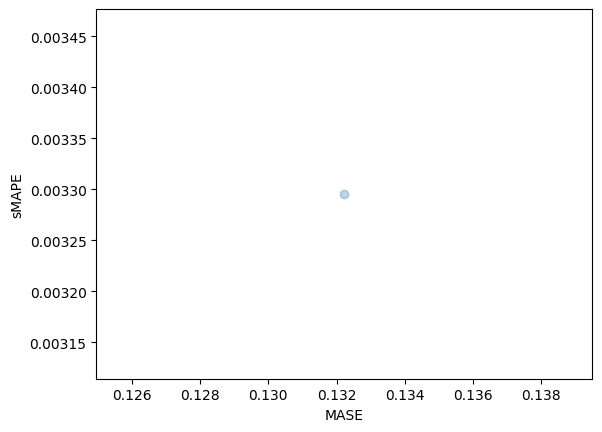

In [63]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()